1.0


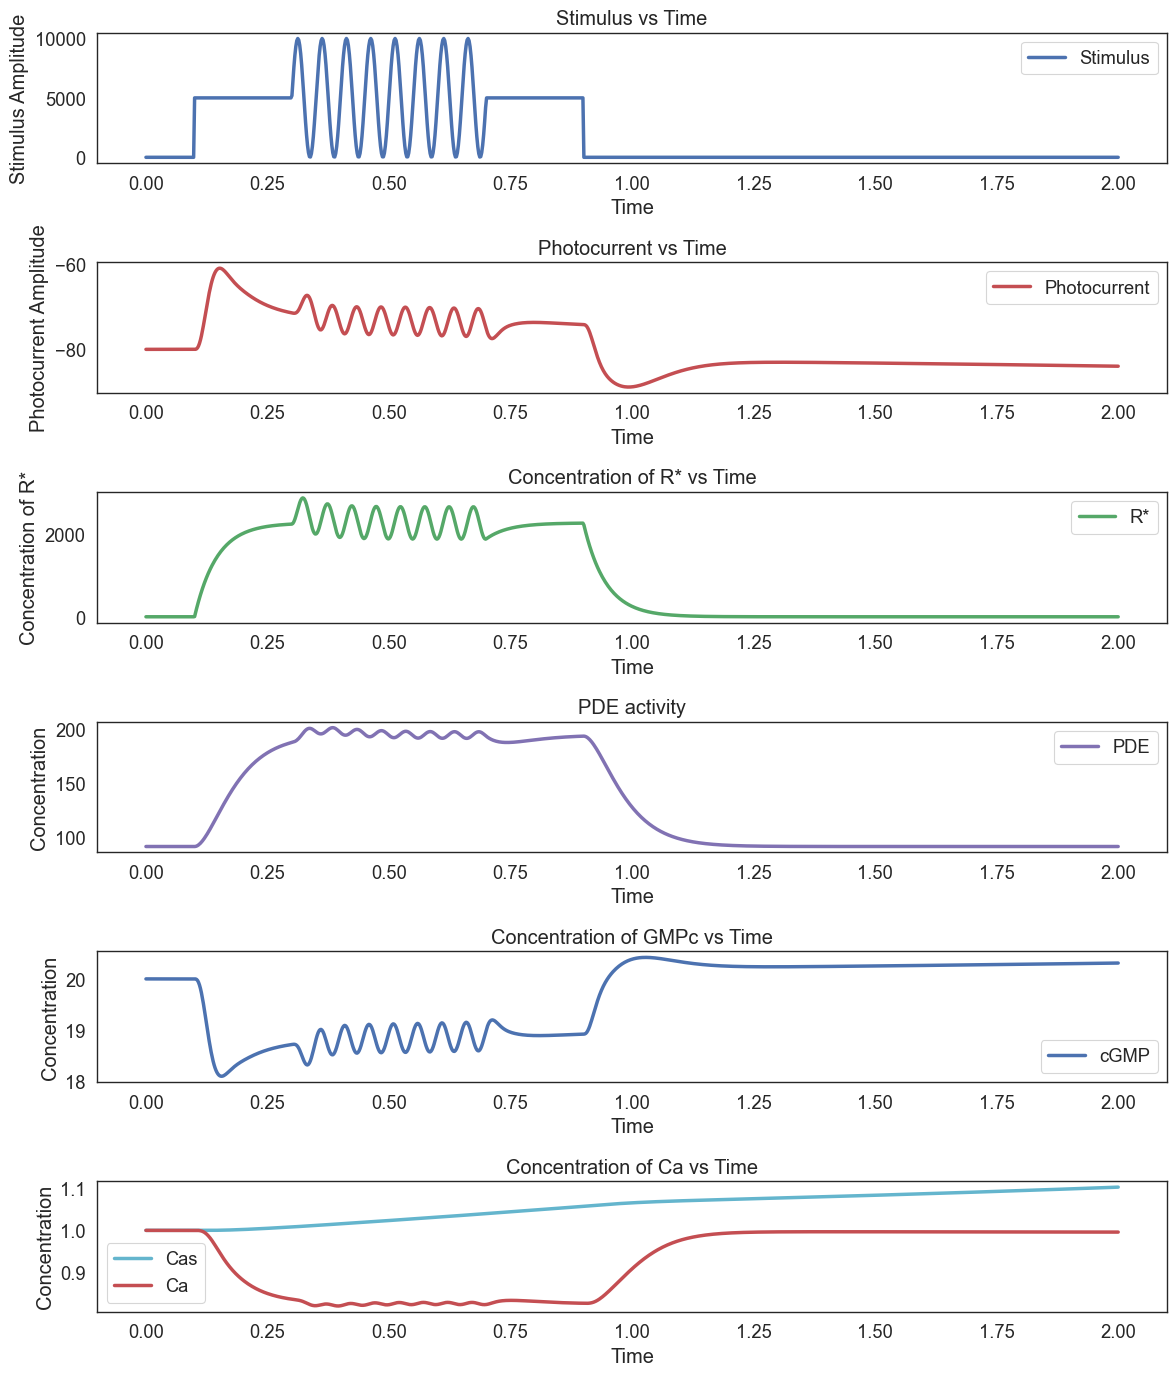

In [31]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the time-dependent equations for the phototransduction model
def pr(u, t, s, Gamma, sigma, phi, eta, Smax, Kgc, m, k, Cad, h, q, beta, betas):
    """
    Define the time-dependent equations for the phototransduction model.

    Parameters:
        u : Vector of concentrations: R*, PDE, cGMP, Ca, Ca_s.
        t : Time function.
        s : Stimulus function.
        Gamma : opsin gain factor.
        sigma : opsin decay rate constant
        phi : PDE decay rate constant
        eta : PDE dark activation rate
        Smax : maximum cGMP synthesis
        Kgc : GC calcium affinity.
        m : Ca cooperativity on GC.
        k : cGMP channel gain constant
        Cad Ca in darkness.
        h : cooperativity of cGMP on channel
        q :fraction of photocurrent carried by calcium
        beta : rate constant of Ca exchange
        betas : decay rate constant of "slow" Ca

    Returns:
        list
            Time derivatives of concentrations.
    """
    R, P, G, Ca, Cas = u
    dRdt = (Gamma * s(t)) - (sigma * R)
    dPdt = R - phi * P + eta
    S = Smax / (1.0 + (Ca / Kgc)**m)
    dGdt = S - (P * G)
    Kca = k / (1.0 + Cas / Cad)
    I = Kca * (G**h) #Check Cas or G
    dCadt = q * I - beta * Ca
    dCasdt = betas * (Cas - Ca)
    #return [dRdt, dPdt, dGdt, dCadt]
    return [dRdt, dPdt, dGdt, dCadt, dCasdt]

def sinewave(t0, tf, phi, f, A):
    """
    Define a sinusoidal stimulus function.

    Parameters:
        t0 : float
            Start time of the stimulus.
        tf : float
            End time of the stimulus.
        phi : float
            Phase angle of the sinusoid.
        f : float
            Frequency of the sinusoid.
        A : float
            Amplitude of the sinusoid.

    Returns:
        function
            Sinusoidal stimulus function.
    """
    return lambda t: A * np.sin(2 * np.pi * f * (t - t0) + phi) * ((t < tf) & (t >= t0))

def square(t0, tf, A):
    """
    Define a square wave stimulus function.

    Parameters:
        t0 : float
            Start time of the square wave.
        tf : float
            End time of the square wave.
        A : float
            Amplitude of the square wave.

    Returns:
        function
            Square wave stimulus function.
    """
    return lambda t: A * ((t < tf) & (t >= t0))


Gamma = 10.0
sigma = 22.0
phi = 22.0
eta = 2000.0
Smax = 30909.0
Kgc = 0.5
m = 4.0
k = 0.02
Cad = 1.0
h = 3.0
q = 0.1125
beta = 9.0
betas = 0.4


Rdark = 0.0
Pdark = eta / phi
Idark = 80.0
Gdark = 20.0
Cas_dark = Cad*((k*Gdark**h/Idark)-1)
print(Cas_dark)
u0 = [Rdark, Pdark, Gdark, Cad, Cas_dark]


tspan = np.linspace(0.0, 2.0, 1000)

# Define the combined stimulus function
a = 5000.0
stimulus_sinewave = sinewave(0.3, 0.7, 0.0, 20.0, a)
stimulus_square = square(0.1, 0.9, a)

def combined_stimulus(t):
    """
    Define the combined stimulus function.

    Parameters:
        t : float
            Time.

    Returns:
        float
            Combined stimulus at time t.
    """
    return stimulus_sinewave(t) + stimulus_square(t)


sol = odeint(pr, u0, tspan, args=(combined_stimulus, Gamma, sigma, phi, eta, Smax, Kgc, m, k, Cad, h, q, beta, betas))
Ca = sol[:, 3]
Cas = sol[:, 4]


# Plot the results
# This makes plots show up and look nice
# matplotlib inline
sns.set(context='paper', style='white', font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_palette('muted')
plt.figure(figsize=(12, 14))

# Plot the stimulus
plt.subplot(6, 1, 1)
plt.plot(tspan, combined_stimulus(tspan), 'b-', label='Stimulus')
plt.xlabel('Time')
plt.ylabel('Stimulus Amplitude')
plt.title('Stimulus vs Time')
plt.legend()

# Plot the photocurrent
plt.subplot(6, 1, 2)
plt.plot(tspan, -k * sol[:, 2]**h / (1.0 + sol[:, 3] / Cad), 'r-', label='Photocurrent')
plt.xlabel('Time')
plt.ylabel('Photocurrent Amplitude')
plt.title('Photocurrent vs Time')
plt.legend()

# Plot the concentration of R*
plt.subplot(6, 1, 3)
plt.plot(tspan, sol[:, 0], 'g-', label='R*')
plt.xlabel('Time')
plt.ylabel('Concentration of R*')
plt.title('Concentration of R* vs Time')
plt.legend()

# Plot the other concentrations
plt.subplot(6, 1, 4)
plt.plot(tspan, sol[:, 1], 'm-', label='PDE')
#plt.plot(tspan, sol[:, 2], 'b-', label='cGMP')
#plt.plot(tspan, sol[:, 3], 'r-', label='Ca')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('PDE activity')
plt.legend()

# Plot gmpc concentration
plt.subplot(6, 1, 5)
plt.plot(tspan, sol[:, 2], 'b-', label='cGMP')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Concentration of GMPc vs Time')
plt.legend()

# Plot Ca concentration
plt.subplot(6, 1, 6)
plt.plot(tspan, Cas, 'c-', label='Cas')
plt.plot(tspan, Ca, 'r-', label='Ca')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Concentration of Ca vs Time')
plt.legend()

plt.tight_layout()
plt.show()


1.0


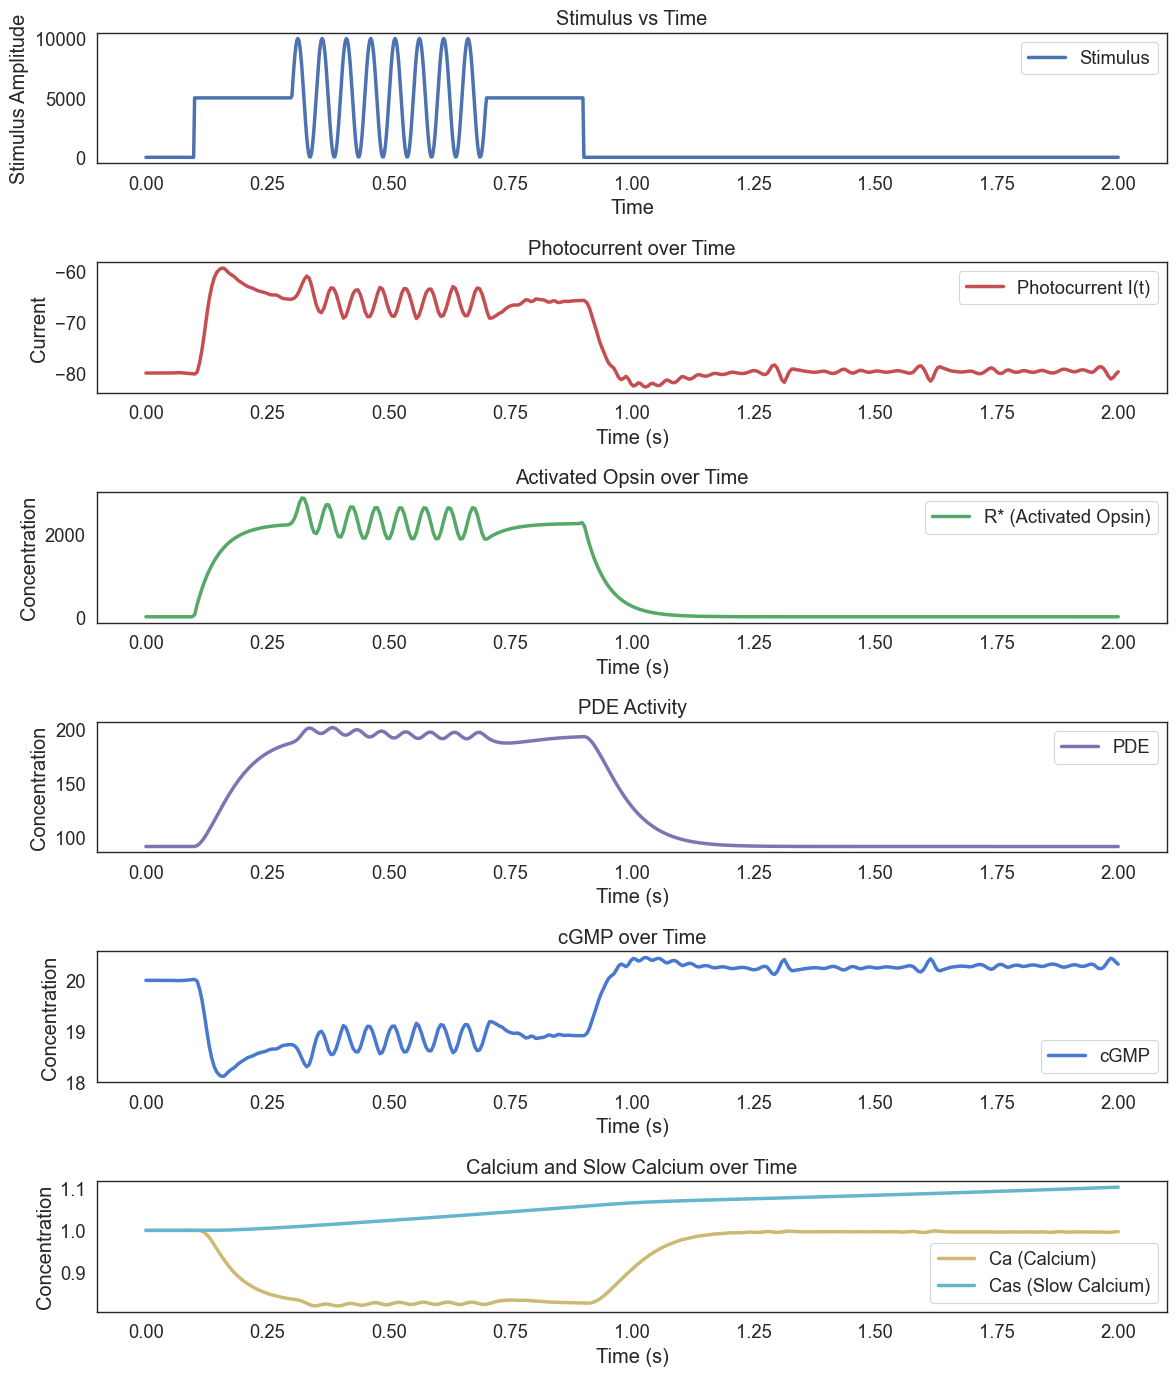

In [39]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def model_differential_equations(t, U, params):
    R, P, G, Ca, Cas = U
    
    # Unpack parameters
    s_func, Gamma, sigma, phi, eta, Smax, Kgc, m, k, Cad, h, q, beta, betas = params
    
    # Current stimulus
    s = s_func(t)
    
    # Differential equations
    dR_dt = Gamma * s - sigma * R
    dP_dt = R - phi * P + eta
    
    S = Smax / (1 + (Ca / Kgc)**m)
    dG_dt = S - P * G
    
    Kca = k / (1 + Cas / Cad)
    I = Kca * (G**h)
    dCa_dt = q * I - beta * Ca
    dCas_dt = betas * (Cas - Ca)
    
    return [dR_dt, dP_dt, dG_dt, dCa_dt, dCas_dt]

# Define the stimulus functions
def sinewave(t0, tf, phi, f, A):
    return lambda t: A * np.sin(2 * np.pi * f * (t - t0) + phi) * (t < tf) * (t >= t0)

def square(t0, tf, A):
    return lambda t: A * (t < tf) * (t >= t0)

# Parameters
Gamma = 10.0
sigma = 22.0
phi = 22.0
eta = 2000.0
Smax = 30909.0
Kgc = 0.5
m = 4.0
k = 0.02
Cad = 1.0
h = 3.0
q = 0.1125
beta = 9.0
betas = 0.4

# Initial conditions
Rdark = 0.0
Pdark = eta / phi
Gdark = 20.0
Idark = 80.0
#Cas_dark = Cad/Idark*(k*Gdark**h-Idark)
Cas_dark = Cad*((k*Gdark**h/Idark)-1)
print(Cas_dark)
u0 = [Rdark, Pdark, Gdark, Cad, Cas_dark]

# Time span
t_span = (0.0, 2.0)

# Stimulus function
a = 5000.0
stimulus = lambda t: sinewave(0.3, 0.7, 0.0, 20.0, a)(t) + square(0.1, 0.9, a)(t)

# Pack parameters together with stimulus
params = [stimulus, Gamma, sigma, phi, eta, Smax, Kgc, m, k, Cad, h, q, beta, betas]

# Solve the ODEs
sol = solve_ivp(model_differential_equations, t_span, u0, args=(params,), method='RK45', dense_output=True)
#sol = odeint(model_differential_equations, u0, t_span, args=(params,))
# Extract the solution
t = np.linspace(t_span[0], t_span[1], 400)
R, P, G, Ca, Cas = sol.sol(t)

# Calculate photocurrent I for the plot
Kca = k / (1 + Cas / Cad)
I = Kca * G**h

# Plotting the results
plt.figure(figsize=(12, 14))

# Plot the stimulus
plt.subplot(6, 1, 1)
plt.plot(tspan, combined_stimulus(tspan), 'b-', label='Stimulus')
plt.xlabel('Time')
plt.ylabel('Stimulus Amplitude')
plt.title('Stimulus vs Time')
plt.legend()

plt.subplot(6, 1, 2)
plt.plot(t, -I,  'r', label='Photocurrent I(t)')
plt.title('Photocurrent over Time')
plt.xlabel('Time (s)')
plt.ylabel('Current')
plt.legend()

plt.subplot(6, 1, 3)
plt.plot(t, R, 'g-', label='R* (Activated Opsin)')
plt.title('Activated Opsin over Time')
plt.xlabel('Time (s)')
plt.ylabel('Concentration')
plt.legend()

plt.subplot(6, 1, 4)
plt.plot(t, P, 'm-', label='PDE')
#plt.plot(t, G, label='cGMP')
plt.title('PDE Activity')
plt.xlabel('Time (s)')
plt.ylabel('Concentration')
plt.legend()

plt.subplot(6, 1, 5)
#plt.plot(t, P, label='PDE')
plt.plot(t, G, label='cGMP')
plt.title('cGMP over Time')
plt.xlabel('Time (s)')
plt.ylabel('Concentration')
plt.legend()

plt.subplot(6, 1, 6)
plt.plot(t, Ca, 'y-', label='Ca (Calcium)')
plt.plot(t, Cas, 'c-', label='Cas (Slow Calcium)')
plt.title('Calcium and Slow Calcium over Time')
plt.xlabel('Time (s)')
plt.ylabel('Concentration')
plt.legend()

plt.tight_layout()
plt.show()
